In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()
import torch

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist
import plot_loss
from torch import optim
from tqdm.notebook import trangehttp://127.0.0.1:8888/lab?token=90058adfa871b2d49e3eb6b39bdcb4b0ac591cab082758b9

# Prepare the dataset

In [2]:
#df = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
df = ak.from_parquet("all_jets_v6.parquet")

In [3]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

In [4]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [5]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

initial_pz = 6500*(generator_info.x1 - generator_info.x2)
initial_E = 6500*(generator_info.x1 + generator_info.x2)

initial_boost = ak.Array(
    {"px": np.zeros_like(initial_pz), "py": np.zeros_like(initial_pz), "pz": initial_pz, "E": initial_E},
    with_name="Momentum4D"
)

## Convert the dataset to torch

In [6]:
y_cond = np.stack( [ 
    ak.to_numpy(boost_jets.pz, allow_missing=None),
    ak.to_numpy(boost_jets.E, allow_missing=None)]).T

y_cond

array([[ 420.4063307 ,  504.85152291],
       [1817.42815781, 1947.97302366],
       [-309.24619865,  452.58669313],
       ...,
       [-631.43818474,  894.70029416],
       [-513.26002884,  764.28309878],
       [ -75.67524624,  935.05256068]])

In [7]:
# Rescaling
y_cond_scaled = torch.from_numpy(np.sign(y_cond)*np.log(abs(y_cond))).float()

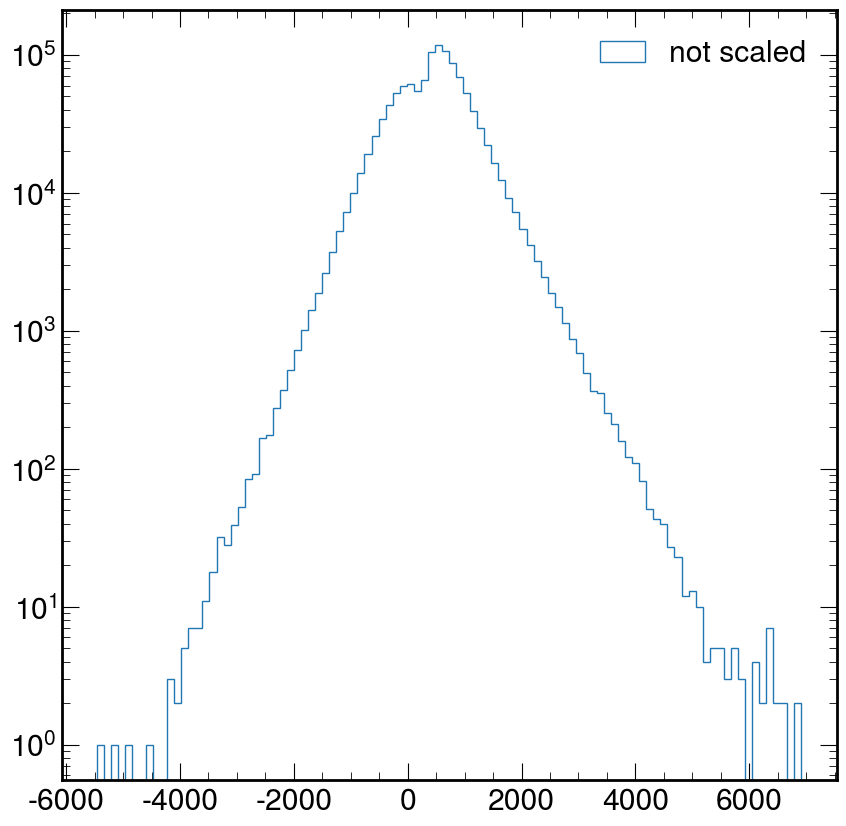

In [8]:
plt.hist(y_cond.flatten(), bins=100, histtype="step", label="not scaled");
plt.yscale("log")
plt.legend();

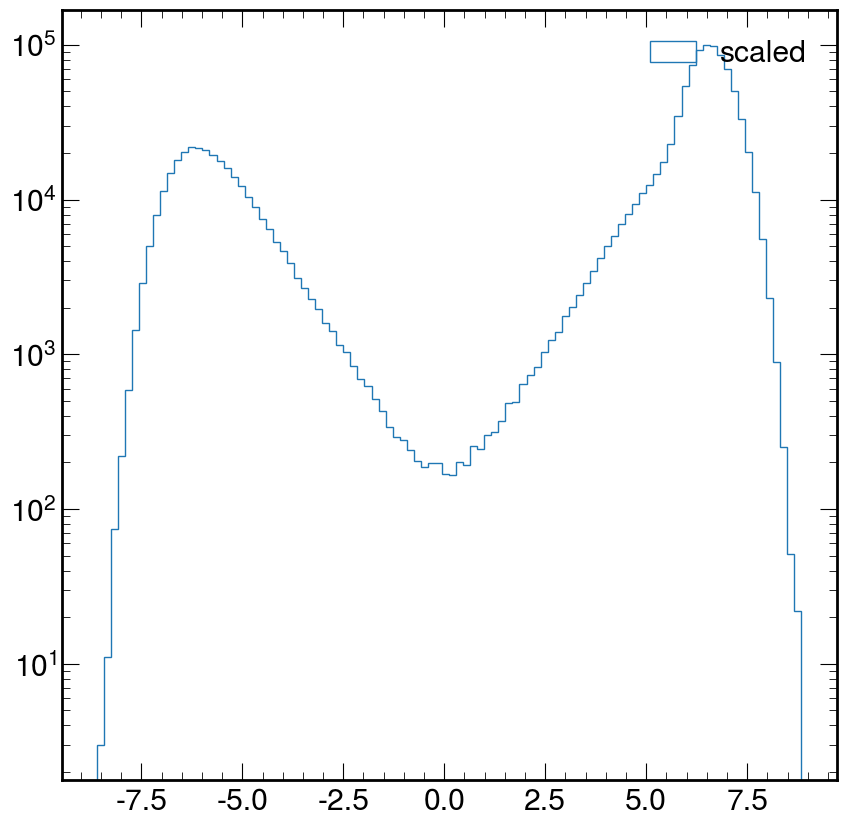

In [9]:
plt.hist(y_cond_scaled.flatten(), bins=100,histtype="step", label="scaled");
plt.yscale("log")
plt.legend();

In [10]:
x_target = np.stack( [ 
    ak.to_numpy(generator_info.x1, allow_missing=None),
    ak.to_numpy(generator_info.x2, allow_missing=None)]).T

x_target_torch = torch.from_numpy(x_target).float()

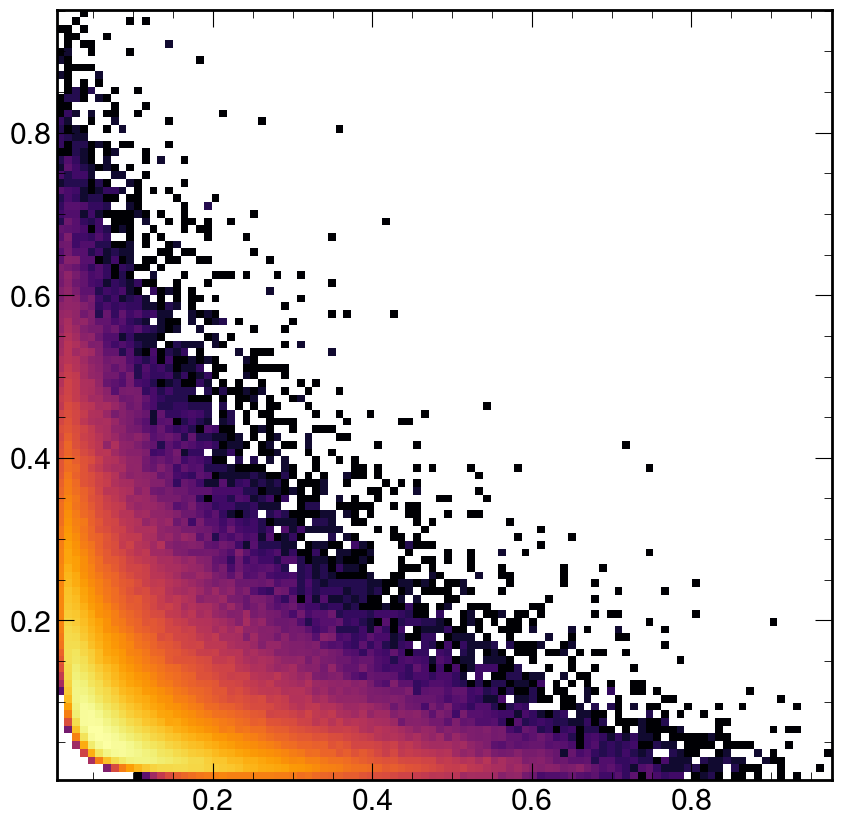

In [13]:
plt.hist2d(x_target[:,0], x_target[:,1], bins=100, cmap="inferno", cmin=1, norm=LogNorm());

# Define the flow

In [11]:
import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform, DiagNormal

In [ ]:
flow = zuko.flows.MAF(2, context=2, transforms=6, hidden_features=[32, 32], 
                      randperm=True,
                      base=DiagNormal)

In [12]:
def build_flow(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes= 2 if not autoregressive else features)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
flow = build_flow(features=2, ntransforms=3, context=2, hidden_mlp=[32], bins=8, autoregressive=True)

In [14]:
flow

NSF(
  (transforms): ModuleList(
    (0): SimpleAffineTransform([tensor([0., 0.]), tensor([1., 1.])] -> [tensor([-1., -1.]), tensor([1., 1.])])
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (3): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear

In [64]:
y_cond_scaled

tensor([[ 6.0412,  6.2243],
        [ 7.5052,  7.5745],
        [-5.7341,  6.1150],
        ...,
        [-6.4480,  6.7965],
        [-6.2408,  6.6389],
        [-4.3265,  6.8406]])

In [65]:
y_cond_scaled.shape

torch.Size([584143, 2])

In [41]:
out = flow(y_cond_scaled).sample((1, )).squeeze(0)
out.shape

torch.Size([584143, 2])

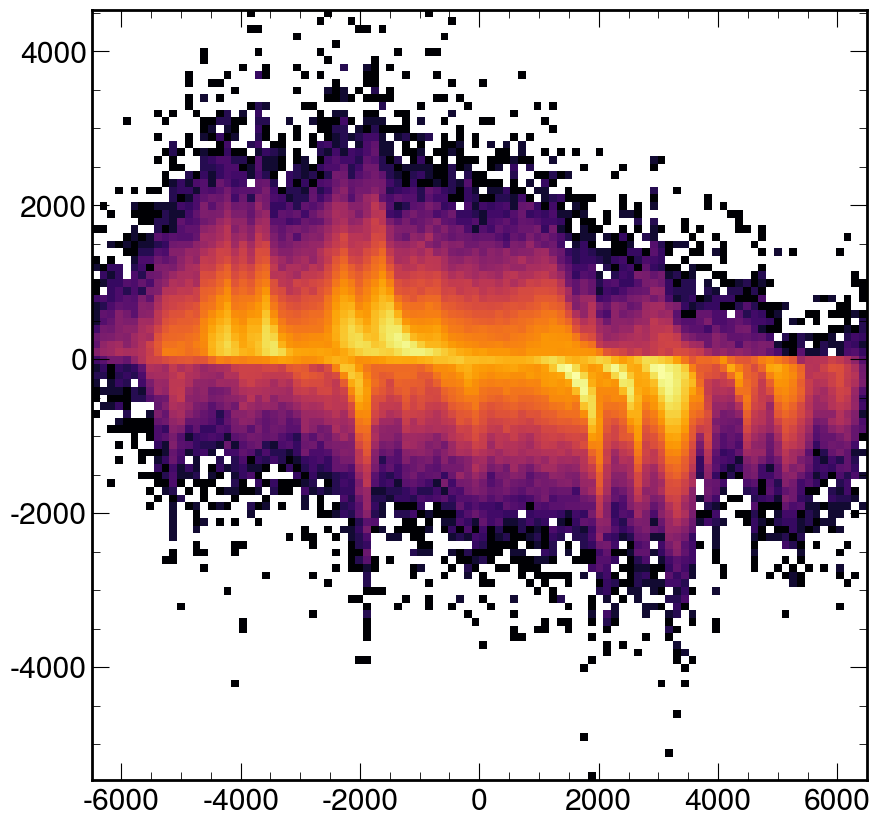

In [42]:
plt.hist2d(6500*(out[:,0]-out[:,1]).numpy(), 
           y_cond[:,0], 
          bins=100,cmap="inferno", cmin=1, norm=LogNorm() );

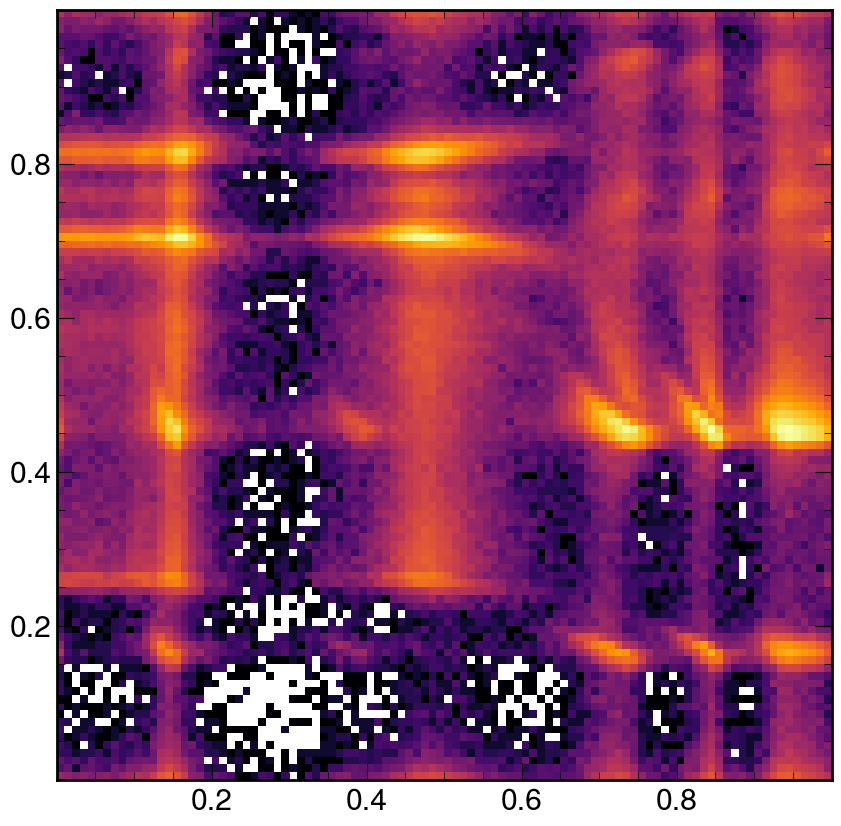

In [43]:
plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
           bins=100, cmap="inferno", cmin=1, norm=LogNorm());

In [37]:
out[0]

tensor([[ 0.5265,  1.6268],
        [ 2.5005,  1.5252],
        [ 0.8062,  0.9308],
        ...,
        [ 1.1791, -0.0298],
        [ 1.7304,  0.1666],
        [ 0.3825, -0.4205]])

# Training loop

In [49]:
nepochs = 10
batch_size = 1024
lr_init = 0.0001
N_training_samples = len(y_cond_scaled)

In [50]:
flow = build_flow(features=2, ntransforms=2, context=2, hidden_mlp=[16,16], bins=8, autoregressive=True)
optimizer = optim.Adam(flow.parameters(), lr=lr_init)

decay = 0.01
fcn = lambda step: 1./(1. + decay*step)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss"])

print(count_parameters(flow))

2268


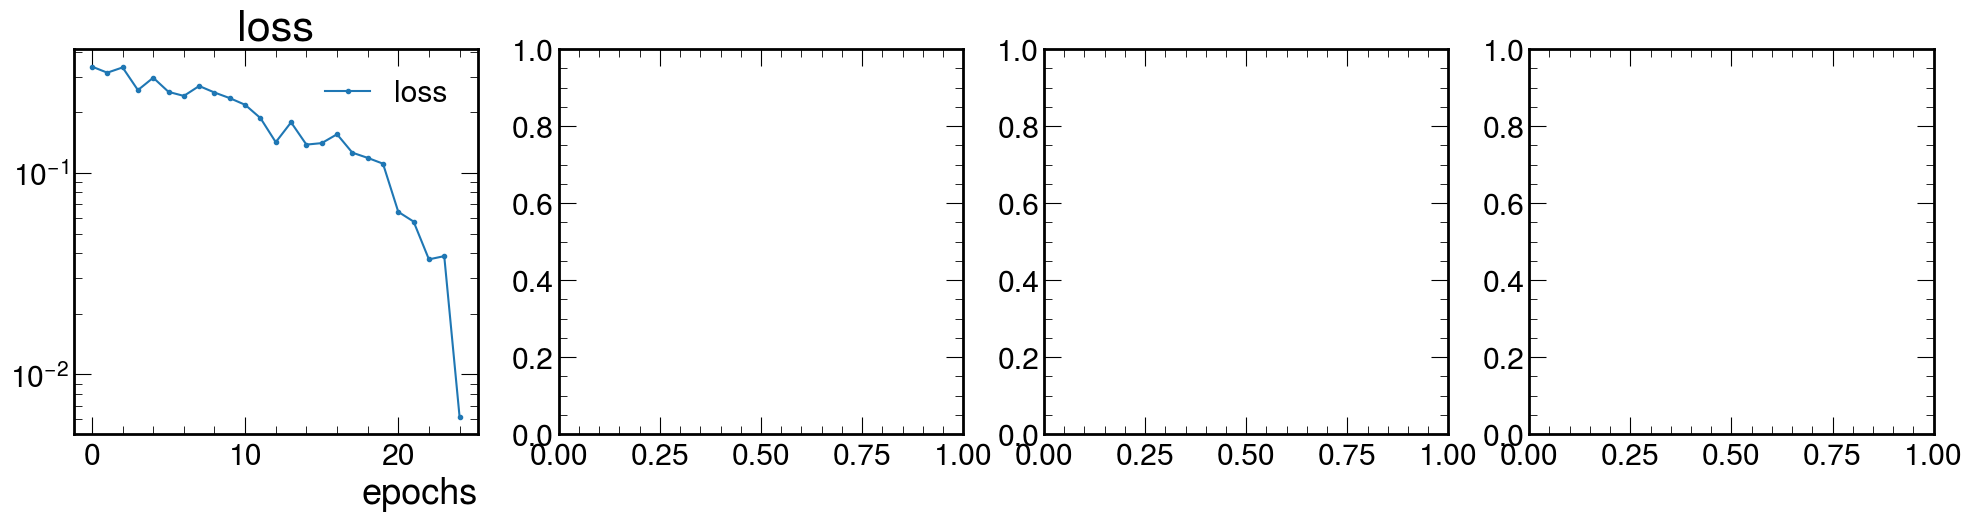

KeyboardInterrupt: 

In [51]:
for i in range(nepochs):
    
    permutation = torch.randperm(N_training_samples)

    for i in trange(0, N_training_samples, batch_size, desc="Batch"):
            
        indices = permutation[i:i+batch_size]
        
        # Computing the reversed KL divergence loss
        optimizer.zero_grad()

        # Adding log(detRambo^-1) = - log(detRambo) to the jacobian
        logp_g =  flow(y_cond_scaled[indices]).log_prob(x_target_torch[indices])

        loss =  - logp_g.mean()
        loss.backward()

        optimizer.step()     

        plotter.on_epoch_end({"loss": loss.item()})

        

In [ ]:
out = flow(y_cond_scaled).sample((1, )).squeeze(0)
out.shape

plt.hist2d(6500*(out[:,0]-out[:,1]).numpy(), 
           y_cond[:,0], 
          bins=100,cmap="inferno", cmin=1, norm=LogNorm() );
plt.xlabel("Pz generated")
plt.ylabel("Pz reco (conditioning)")